# 🗺️ SINGLE STRAIT DOT ANALYSIS
## Jason-1/2 Satellite Altimetry - Detailed Strait Analysis

This notebook performs **comprehensive DOT analysis for a SINGLE strait**:
- Single pass analysis with longitude binning (0.01°)
- 3-panel DOT plot (slope timeline, profile, map)
- Monthly DOT analysis (12 subplots)
- Slope timeline with error bars

**Method**: All plots use 0.01° longitude binning with linear fit for slope calculation.

In [19]:
# ========================================
# 📚 IMPORT LIBRARIES
# ========================================

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import sys
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
from scipy import stats
from scipy.interpolate import RegularGridInterpolator
from shapely.geometry import LineString
import glob

# Import custom functions
sys.path.append("/Users/nicolocaron/Desktop/ARCFRESH")
sys.path.append("/Users/nicolocaron/Documents/GitHub/arcfresh-dtu/SOLID CODE")
from j2_utils import (
    load_filtered_cycles_serial_J2,
    interpolate_geoid,
    add_geoid_to_cycles,
    filter_pass_from_cycles,
    extract_strait_info,
    find_closest_pass_to_gate,
)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [20]:
# ========================================
# 🎯 CONFIGURATION - MODIFY HERE
# ========================================

# 1. SELECT STRAIT
SELECTED_STRAIT = "davis"  # Options: "davis", "fram", "bering"

# 2. SELECT PASS NUMBER
PASS_NUMBER = 248  # Set the pass number to analyze

# 3. FILE PATHS
GATES_FOLDER = "/Users/nicolocaron/Desktop/ARCFRESH/ArcticCoast_Sara_4/gates"
BASE_DIR = Path("/Users/nicolocaron/Desktop/ARCFRESH/J2")  # or J1 for Jason-1
GEOID_PATH = "/Users/nicolocaron/Desktop/ARCFRESH/TUM_ogmoc.nc"

# 4. OUTPUT SETTINGS
SAVE_OUTPUTS = True
OUTPUT_DIR = Path("/Users/nicolocaron/Desktop/ARCFRESH/plot slccii/SINGLE_STRAIT")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 5. PROCESSING SETTINGS
USE_FLAG = True  # Use quality flags for data filtering
LON_BIN_SIZE = 0.01  # Longitude bin size in degrees

print("\n" + "=" * 70)
print("📋 CONFIGURATION")
print("=" * 70)
print(f"🌊 Strait: {SELECTED_STRAIT.upper()}")
print(f"🛰️  Pass: {PASS_NUMBER}")
print(f"📂 Data directory: {BASE_DIR}")
print(f"💾 Output directory: {OUTPUT_DIR}")
print(f"📊 Longitude bin size: {LON_BIN_SIZE}°")
print("=" * 70)


📋 CONFIGURATION
🌊 Strait: DAVIS
🛰️  Pass: 248
📂 Data directory: /Users/nicolocaron/Desktop/ARCFRESH/J2
💾 Output directory: /Users/nicolocaron/Desktop/ARCFRESH/plot slccii/SINGLE_STRAIT
📊 Longitude bin size: 0.01°


In [21]:
# ========================================
# 🛰️ SATELLITE CONFIGURATION
# ========================================

mission = BASE_DIR.name.upper()
if mission == "J2":
    cycles = list(range(1, 282))
    satellite_name = "J2"
elif mission == "J1":
    cycles = list(range(1, 538))
    satellite_name = "J1"
else:
    cycles = list(range(1, 282))
    satellite_name = mission

print(f"\n🛰️ Satellite: {satellite_name}")
print(f"📊 Total cycles: {len(cycles)}")
print(f"🔢 Cycle range: {cycles[0]} to {cycles[-1]}")


🛰️ Satellite: J2
📊 Total cycles: 281
🔢 Cycle range: 1 to 281


In [22]:
# ========================================
# 🌍 LOAD GEOID INTERPOLATOR
# ========================================

print("\n🔄 Loading TUM_ogmoc geoid...")

ds_geoid = xr.open_dataset(GEOID_PATH)
lat_geoid = ds_geoid["lat"].values
lon_geoid = ds_geoid["lon"].values
geoid_values = ds_geoid["value"].values

# Wrap longitudes to [-180, 180] and sort
lon_wrapped = ((lon_geoid + 180) % 360) - 180
sort_idx = np.argsort(lon_wrapped)
lon_sorted = lon_wrapped[sort_idx]
unique_idx = np.concatenate(([True], np.diff(lon_sorted) != 0))
lon_sorted = lon_sorted[unique_idx]
geoid_sorted = geoid_values[:, sort_idx][:, unique_idx]

GEOID_INTERP = RegularGridInterpolator(
    (lat_geoid, lon_sorted),
    geoid_sorted,
    method="nearest",
    bounds_error=False,
    fill_value=np.nan,
)

print("✅ Geoid interpolator ready!")


🔄 Loading TUM_ogmoc geoid...
✅ Geoid interpolator ready!


In [23]:
# ========================================
# 📍 LOAD GATE SHAPEFILE
# ========================================

# Map strait names to search patterns
STRAIT_PATTERNS = {
    "davis": "*davis*.shp",
    "fram": "*fram*.shp",
    "bering": "*bering*.shp"
}

# Find gate file
if SELECTED_STRAIT.lower() in STRAIT_PATTERNS:
    pattern = str(Path(GATES_FOLDER) / STRAIT_PATTERNS[SELECTED_STRAIT.lower()])
    gate_files = glob.glob(pattern)
    if gate_files:
        GATE_PATH = gate_files[0]
        print(f"\n✅ Found gate: {Path(GATE_PATH).name}")
    else:
        raise FileNotFoundError(f"❌ No gate file found for '{SELECTED_STRAIT}' with pattern {pattern}")
else:
    raise ValueError(f"❌ Invalid strait name: '{SELECTED_STRAIT}'. Must be 'davis', 'fram', or 'bering'")

# Extract strait info
strait_name, _ = extract_strait_info(GATE_PATH)
print(f"📍 Strait name: {strait_name}")

# Load gate geometry
gate = gpd.read_file(GATE_PATH).to_crs("EPSG:4326")
gate_bounds = gate.total_bounds
print(f"✅ Gate loaded: {len(gate)} features")
print(f"   Bounds: lon [{gate_bounds[0]:.2f}, {gate_bounds[2]:.2f}], lat [{gate_bounds[1]:.2f}, {gate_bounds[3]:.2f}]")


✅ Found gate: davis_strait.shp
📍 Strait name: Davis Strait
✅ Gate loaded: 1 features
   Bounds: lon [-64.40, -52.98], lat [67.68, 68.16]


In [24]:
# ========================================
# 🔄 LOAD SATELLITE DATA
# ========================================

print(f"\n🔄 Loading satellite data for Pass {PASS_NUMBER}...")

# Load data
ds_pass = load_filtered_cycles_serial_J2(
    cycles=cycles,
    gate_path=GATE_PATH,
    base_dir=str(BASE_DIR),
    use_flag=USE_FLAG,
    pass_number=PASS_NUMBER,
)

n_points = ds_pass.sizes.get("time", 0)
if n_points == 0:
    raise ValueError(f"❌ No data found for Pass {PASS_NUMBER}")

print(f"   Raw data points: {n_points}")

# Interpolate geoid
geoid_interp = interpolate_geoid(
    geoid_path=GEOID_PATH,
    target_lats=ds_pass["latitude"].values,
    target_lons=ds_pass["longitude"].values,
)

# Add geoid and filter by pass
sub_cycles = add_geoid_to_cycles(ds_pass, geoid_interp)
sub_cycles_pass = filter_pass_from_cycles(sub_cycles, PASS_NUMBER)

# Build DataFrame
data_list = []
for cycle_num, ds_cycle in sub_cycles_pass.items():
    dot = ds_cycle["corssh"].values - ds_cycle["geoid"].values
    df_cycle = pd.DataFrame({
        "cycle": cycle_num,
        "pass": PASS_NUMBER,
        "lat": ds_cycle["latitude"].values,
        "lon": ds_cycle["longitude"].values,
        "corssh": ds_cycle["corssh"].values,
        "geoid": ds_cycle["geoid"].values,
        "dot": dot,
        "time": pd.to_datetime(ds_cycle["time"].values),
    })
    data_list.append(df_cycle)

if not data_list:
    raise ValueError(f"❌ No valid data after processing for Pass {PASS_NUMBER}")

# Combine all cycles
j2_data = pd.concat(data_list, ignore_index=True)
j2_data["month"] = j2_data["time"].dt.month
j2_data["year"] = j2_data["time"].dt.year

print(f"\n✅ Data loaded successfully!")
print(f"   Total observations: {len(j2_data)}")
print(f"   Unique cycles: {j2_data['cycle'].nunique()}")
print(f"   Time range: {j2_data['time'].min()} to {j2_data['time'].max()}")
print(f"   Longitude range: {j2_data['lon'].min():.3f}° to {j2_data['lon'].max():.3f}°")
print(f"   Latitude range: {j2_data['lat'].min():.3f}° to {j2_data['lat'].max():.3f}°")
print(f"   DOT range: {j2_data['dot'].min():.3f} to {j2_data['dot'].max():.3f} m")


🔄 Loading satellite data for Pass 248...
🛰️ Detected satellite type: J2
🌊 Search window: lon=[-69.40, -47.98], lat=[65.68, 70.16]

📁 Cycle 1: opening SLCCI_ALTDB_J2_Cycle001_V2.nc
   Variables in file: ['time', 'latitude', 'longitude', 'cycle', 'pass', 'TimeDay', 'TimeSec', 'TimeMicroSec', 'corssh', 'alt', 'range', 'sea_state_bias', 'iono_corr', 'gpd_wet_tropo_corr', 'alt_flag_oper', 'bathymetry', 'dyn_atmosph_corr', 'dry_tropo_corr', 'rad_wet_tropo_corr', 'model_wet_tropo_corr', 'mean_sea_surface', 'ocean_tide', 'loading_tide', 'pole_tide', 'sigma0', 'solid_earth_tide', 'swh', 'range_numval', 'range_rms', 'sigma0_numval', 'sigma0_rms', 'validation_flag', 'rad_surf_type', 'regional_bias', 'global_bias', 'alt_surf_type', 'ice_flag', 'rad_qual_interp_flag', 'off_nadir_angle', 'wind_speed_alt']
   ✅ Quality filter: 308/623 points (validation_flag == 0)
   🔎 Detected pass variable: 'pass'
   🎯 Cycle 1: 58 points for pass 248
   ✅ Quality filter: 308/623 points (validation_flag == 0)
   🔎 

/Users/nicolocaron/Documents/GitHub/arcfresh-dtu/SOLID CODE/j2_utils.py:95: RuntimeWarning: invalid value encountered in add
  return ((arr + 180) % 360) - 180


   ✅ Quality filter: 397/533 points (validation_flag == 0)
   🔎 Detected pass variable: 'pass'
   ⚠️ Cycle 82: pass 248 not found (variable 'pass')

📁 Cycle 83: opening SLCCI_ALTDB_J2_Cycle083_V2.nc
   Variables in file: ['time', 'latitude', 'longitude', 'cycle', 'pass', 'TimeDay', 'TimeSec', 'TimeMicroSec', 'corssh', 'alt', 'range', 'sea_state_bias', 'iono_corr', 'gpd_wet_tropo_corr', 'alt_flag_oper', 'bathymetry', 'dyn_atmosph_corr', 'dry_tropo_corr', 'rad_wet_tropo_corr', 'model_wet_tropo_corr', 'mean_sea_surface', 'ocean_tide', 'loading_tide', 'pole_tide', 'sigma0', 'solid_earth_tide', 'swh', 'range_numval', 'range_rms', 'sigma0_numval', 'sigma0_rms', 'validation_flag', 'rad_surf_type', 'regional_bias', 'global_bias', 'alt_surf_type', 'ice_flag', 'rad_qual_interp_flag', 'off_nadir_angle', 'wind_speed_alt']
   ✅ Quality filter: 526/694 points (validation_flag == 0)
   🔎 Detected pass variable: 'pass'
   🎯 Cycle 83: 59 points for pass 248

📁 Cycle 84: opening SLCCI_ALTDB_J2_Cycle084_

/Users/nicolocaron/Documents/GitHub/arcfresh-dtu/SOLID CODE/j2_utils.py:95: RuntimeWarning: invalid value encountered in add
  return ((arr + 180) % 360) - 180


   ✅ Quality filter: 97/321 points (validation_flag == 0)
   🔎 Detected pass variable: 'pass'
   ⚠️ Cycle 108: pass 248 not found (variable 'pass')

📁 Cycle 109: opening SLCCI_ALTDB_J2_Cycle109_V2.nc
   Variables in file: ['time', 'latitude', 'longitude', 'cycle', 'pass', 'TimeDay', 'TimeSec', 'TimeMicroSec', 'corssh', 'alt', 'range', 'sea_state_bias', 'iono_corr', 'gpd_wet_tropo_corr', 'alt_flag_oper', 'bathymetry', 'dyn_atmosph_corr', 'dry_tropo_corr', 'rad_wet_tropo_corr', 'model_wet_tropo_corr', 'mean_sea_surface', 'ocean_tide', 'loading_tide', 'pole_tide', 'sigma0', 'solid_earth_tide', 'swh', 'range_numval', 'range_rms', 'sigma0_numval', 'sigma0_rms', 'validation_flag', 'rad_surf_type', 'regional_bias', 'global_bias', 'alt_surf_type', 'ice_flag', 'rad_qual_interp_flag', 'off_nadir_angle', 'wind_speed_alt']
   ✅ Quality filter: 208/701 points (validation_flag == 0)
   🔎 Detected pass variable: 'pass'
   🎯 Cycle 109: 33 points for pass 248

📁 Cycle 110: opening SLCCI_ALTDB_J2_Cycle1


🔄 Creating DOT map...
💾 Saved: /Users/nicolocaron/Desktop/ARCFRESH/plot slccii/SINGLE_STRAIT/DOT_map_J2_pass248_davis.png
💾 Saved: /Users/nicolocaron/Desktop/ARCFRESH/plot slccii/SINGLE_STRAIT/DOT_map_J2_pass248_davis.png


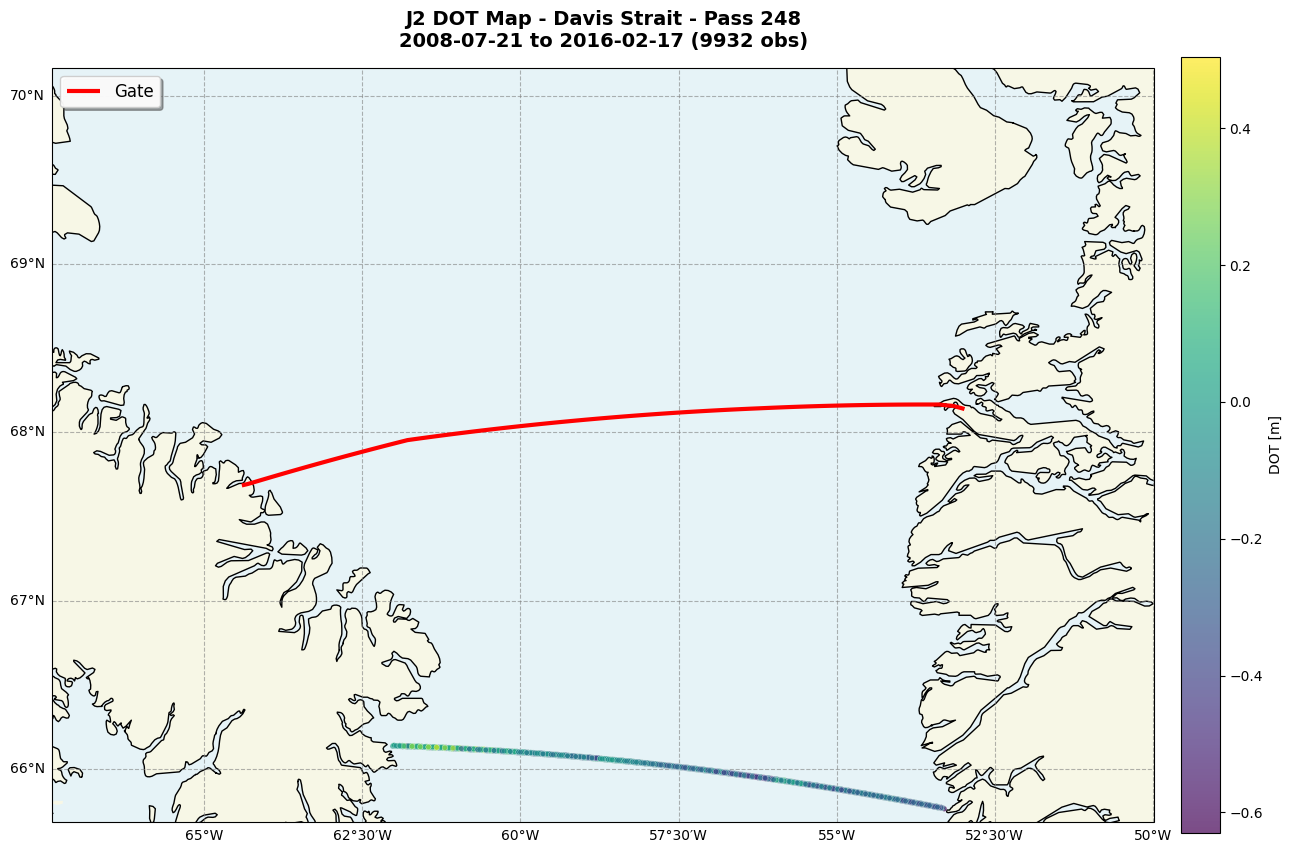

✅ DOT map complete!


In [25]:
# ========================================
# 🗺️ DOT MAP VISUALIZATION
# ========================================

print("\n🔄 Creating DOT map...")

# Map extent with buffer
LON_BUFFER = 3.0
LAT_BUFFER = 2.0
MAP_EXTENT = [
    gate_bounds[0] - LON_BUFFER,
    gate_bounds[2] + LON_BUFFER,
    gate_bounds[1] - LAT_BUFFER,
    gate_bounds[3] + LAT_BUFFER,
]

# Create figure
proj = ccrs.PlateCarree()
fig_map, ax_map = plt.subplots(figsize=(14, 10), subplot_kw=dict(projection=proj))

# Add map features
ax_map.coastlines(linewidth=1.0)
ax_map.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
ax_map.add_feature(cfeature.LAND, facecolor="beige", alpha=0.7)
ax_map.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.3)
ax_map.set_extent(MAP_EXTENT, crs=proj)

# Add gridlines
gl = ax_map.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,
                      linewidth=0.8, alpha=0.6, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels = False

# Plot gate
gate.plot(ax=ax_map, color="red", linewidth=3, transform=proj, zorder=10, label='Gate')

# Plot DOT data
sc = ax_map.scatter(
    j2_data["lon"], j2_data["lat"],
    c=j2_data["dot"],
    s=15,
    marker='o',
    alpha=0.7,
    cmap='viridis',
    transform=proj,
    zorder=5,
    edgecolors='white',
    linewidths=0.2,
)

plt.colorbar(sc, ax=ax_map, orientation='vertical', label='DOT [m]', shrink=0.8, pad=0.02)
ax_map.legend(loc='upper left', fontsize=12, framealpha=0.95, shadow=True)

# Title
title = f'{satellite_name} DOT Map - {strait_name} - Pass {PASS_NUMBER}\n'
title += f'{j2_data["time"].min().strftime("%Y-%m-%d")} to {j2_data["time"].max().strftime("%Y-%m-%d")} ({len(j2_data)} obs)'
ax_map.set_title(title, fontsize=14, fontweight='bold', pad=15)

plt.tight_layout()

if SAVE_OUTPUTS:
    fname = f"DOT_map_{satellite_name}_pass{PASS_NUMBER}_{SELECTED_STRAIT}.png"
    plt.savefig(OUTPUT_DIR / fname, dpi=300, bbox_inches='tight')
    print(f"💾 Saved: {OUTPUT_DIR / fname}")

plt.show()
print("✅ DOT map complete!")


🔄 Creating 3-panel DOT plot...
   Time periods: 88 months
   Longitude bins: 872 (from -62.020° to -53.300°)
   Valid DOT values: 9020 / 76736 (11.8%)
   Profile bins (coarser): 88 bins of 0.1°

💾 Saved: /Users/nicolocaron/Desktop/ARCFRESH/plot slccii/SINGLE_STRAIT/3panel_DOT_J2_pass248_davis.png

💾 Saved: /Users/nicolocaron/Desktop/ARCFRESH/plot slccii/SINGLE_STRAIT/3panel_DOT_J2_pass248_davis.png


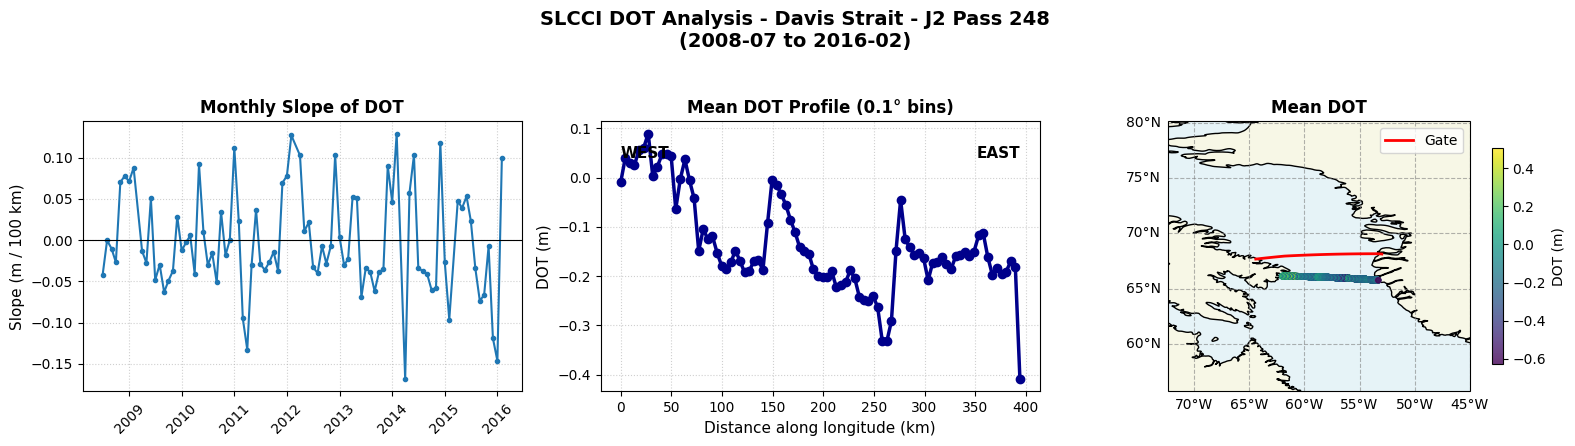


✅ 3-panel plot complete!

💾 Saved: /Users/nicolocaron/Desktop/ARCFRESH/plot slccii/SINGLE_STRAIT/3panel_DOT_J2_pass248_davis.png


<Figure size 640x480 with 0 Axes>

In [29]:
# ========================================
# 📊 3-PANEL DOT PLOT
# ========================================

print("\n🔄 Creating 3-panel DOT plot...")

# ----------------------------------------
# Prepare time periods
# ----------------------------------------
j2_data["year_month"] = pd.to_datetime(j2_data["time"]).dt.to_period("M")
time_periods = sorted(j2_data["year_month"].unique())
ntime = len(time_periods)

print(f"   Time periods: {ntime} months")

# ----------------------------------------
# Build DOT matrix using LONGITUDE BINNING
# ----------------------------------------
lon_min = j2_data["lon"].min()
lon_max = j2_data["lon"].max()
lon_bins = np.arange(lon_min, lon_max + LON_BIN_SIZE, LON_BIN_SIZE)
lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
n_lon_bins = len(lon_centers)

print(f"   Longitude bins: {n_lon_bins} (from {lon_min:.3f}° to {lon_max:.3f}°)")

# Create matrix: rows = longitude bins, columns = time periods
dot_gate = np.full((n_lon_bins, ntime), np.nan, dtype=float)

# Fill matrix by binning data for each time period
for it, period in enumerate(time_periods):
    month_data = j2_data[j2_data["year_month"] == period].copy()
    if month_data.empty:
        continue
    
    # Bin by longitude
    month_data["lon_bin"] = pd.cut(
        month_data["lon"], 
        bins=lon_bins, 
        labels=False, 
        include_lowest=True
    )
    
    # Average DOT in each longitude bin
    binned = month_data.groupby("lon_bin")["dot"].mean()
    
    # Fill matrix
    for bin_idx in binned.index:
        if bin_idx < n_lon_bins:
            dot_gate[bin_idx, it] = binned[bin_idx]

valid_pct = 100 * np.sum(np.isfinite(dot_gate)) / dot_gate.size
print(f"   Valid DOT values: {np.sum(np.isfinite(dot_gate))} / {dot_gate.size} ({valid_pct:.1f}%)")

# ----------------------------------------
# Calculate distance in km
# ----------------------------------------
R_earth = 6371.0
mean_lat = j2_data["lat"].mean()
lat_rad = np.deg2rad(mean_lat)
lon_rad = np.deg2rad(lon_centers)
dlon = lon_rad - lon_rad[0]
x_km = R_earth * np.abs(dlon) * np.cos(lat_rad)

# ----------------------------------------
# Compute slope time series
# ----------------------------------------
slope_series = np.full(ntime, np.nan, dtype=float)
for it in range(ntime):
    y = dot_gate[:, it]
    mask = np.isfinite(x_km) & np.isfinite(y)
    if np.sum(mask) < 2:
        continue
    a, _ = np.polyfit(x_km[mask], y[mask], 1)  # m/km
    slope_series[it] = a * 100.0  # m / 100 km

time_array = np.array([pd.Timestamp(str(p)) for p in time_periods])

# ----------------------------------------
# Create COARSER binning for profile visualization (0.1° instead of 0.01°)
# ----------------------------------------
PROFILE_BIN_SIZE = 0.1  # Larger bins for cleaner profile visualization
lon_bins_profile = np.arange(lon_min, lon_max + PROFILE_BIN_SIZE, PROFILE_BIN_SIZE)
lon_centers_profile = (lon_bins_profile[:-1] + lon_bins_profile[1:]) / 2
n_lon_bins_profile = len(lon_centers_profile)

print(f"   Profile bins (coarser): {n_lon_bins_profile} bins of {PROFILE_BIN_SIZE}°")

# Create coarser matrix for profile
dot_profile = np.full((n_lon_bins_profile, ntime), np.nan, dtype=float)

for it, period in enumerate(time_periods):
    month_data = j2_data[j2_data["year_month"] == period].copy()
    if month_data.empty:
        continue
    
    month_data["lon_bin_profile"] = pd.cut(
        month_data["lon"], 
        bins=lon_bins_profile, 
        labels=False, 
        include_lowest=True
    )
    
    binned_profile = month_data.groupby("lon_bin_profile")["dot"].mean()
    
    for bin_idx in binned_profile.index:
        if bin_idx < n_lon_bins_profile:
            dot_profile[bin_idx, it] = binned_profile[bin_idx]

# Mean profile from coarser bins
profile_mean = np.nanmean(dot_profile, axis=1)

# Recalculate distance for profile bins
lon_rad_profile = np.deg2rad(lon_centers_profile)
dlon_profile = lon_rad_profile - lon_rad_profile[0]
x_km_profile = R_earth * np.abs(dlon_profile) * np.cos(lat_rad)

mean_dot_by_loc = j2_data.groupby(["lon", "lat"]).agg({"dot": "mean"}).reset_index()

# ----------------------------------------
# Create 3-panel figure
# ----------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
ax0, ax1, ax2_temp = axes

ax2_temp.remove()
ax2 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())

fig.suptitle(
    f"SLCCI DOT Analysis - {strait_name} - {satellite_name} Pass {PASS_NUMBER}\n"
    f"({time_array[0].strftime('%Y-%m')} to {time_array[-1].strftime('%Y-%m')})",
    fontsize=14,
    fontweight="bold",
)

# Panel 1: Slope time series
ax0.plot(time_array, slope_series, "-o", markersize=3, linewidth=1.5)
ax0.axhline(0, color="k", linewidth=0.8)
ax0.grid(True, linestyle=":", alpha=0.6)
ax0.set_ylabel("Slope (m / 100 km)", fontsize=11)
ax0.set_title("Monthly Slope of DOT", fontsize=12, fontweight="bold")
ax0.tick_params(axis='x', rotation=45)

# Panel 2: Mean DOT profile (using coarser bins)
valid_profile = np.isfinite(profile_mean)
if np.any(valid_profile):
    ax1.plot(x_km_profile[valid_profile], profile_mean[valid_profile], linewidth=2.5, color='darkblue', marker='o', markersize=6)
ax1.grid(True, linestyle=":", alpha=0.6)
ax1.set_xlabel("Distance along longitude (km)", fontsize=11)
ax1.set_ylabel("DOT (m)", fontsize=11)
ax1.set_title(f"Mean DOT Profile ({PROFILE_BIN_SIZE}° bins)", fontsize=12, fontweight="bold")

if np.any(valid_profile):
    y_range = np.nanmax(profile_mean[valid_profile]) - np.nanmin(profile_mean[valid_profile])
    y_text = (
        np.nanmax(profile_mean[valid_profile]) - 0.05 * y_range
        if y_range > 0
        else np.nanmean(profile_mean[valid_profile])
    )
    ax1.text(x_km_profile.min(), y_text, "WEST", fontsize=11, fontweight="bold", ha="left", va="top")
    ax1.text(x_km_profile.max(), y_text, "EAST", fontsize=11, fontweight="bold", ha="right", va="top")

# Panel 3: Mean DOT map
# Sample gate points for display
gate_geom = gate.geometry.iloc[0]
if hasattr(gate_geom, 'geoms'):
    coords = []
    for geom in gate_geom.geoms:
        coords.extend(list(geom.coords))
else:
    coords = list(gate_geom.coords)

line = LineString(coords)
n_pts = 100
distances = np.linspace(0, line.length, n_pts)
points = [line.interpolate(d) for d in distances]
gate_lon_pts = np.array([p.x for p in points])
gate_lat_pts = np.array([p.y for p in points])

lon_buffer = 8.0
lat_buffer = 12.0

ax2.set_extent(
    [
        gate_lon_pts.min() - lon_buffer,
        gate_lon_pts.max() + lon_buffer,
        gate_lat_pts.min() - lat_buffer,
        gate_lat_pts.max() + lat_buffer,
    ],
    crs=ccrs.PlateCarree(),
)

ax2.coastlines(linewidth=1.0)
ax2.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
ax2.add_feature(cfeature.LAND, facecolor="beige", alpha=0.7)
ax2.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.3)

gl = ax2.gridlines(
    draw_labels=True,
    dms=True,
    x_inline=False,
    y_inline=False,
    linewidth=0.8,
    alpha=0.6,
    linestyle="--",
    color="gray",
)
gl.top_labels = False
gl.right_labels = False

sc = ax2.scatter(
    mean_dot_by_loc["lon"],
    mean_dot_by_loc["lat"],
    c=mean_dot_by_loc["dot"],
    s=15,
    cmap="viridis",
    alpha=0.8,
    transform=ccrs.PlateCarree(),
    zorder=3,
)

fig.colorbar(sc, ax=ax2, label="DOT (m)", shrink=0.8)

ax2.plot(
    gate_lon_pts,
    gate_lat_pts,
    color="red",
    linewidth=2,
    transform=ccrs.PlateCarree(),
    label="Gate",
    zorder=5,
)

ax2.set_title("Mean DOT", fontsize=12, fontweight="bold")
ax2.legend(loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.94])

if SAVE_OUTPUTS:
    fname = f"3panel_DOT_{satellite_name}_pass{PASS_NUMBER}_{SELECTED_STRAIT}.png"
    plt.savefig(OUTPUT_DIR / fname, dpi=300, bbox_inches='tight')
    print(f"\n💾 Saved: {OUTPUT_DIR / fname}")

plt.show()
print("\n✅ 3-panel plot complete!")

gl.top_labels = False
gl.right_labels = False

sc = ax2.scatter(
    mean_dot_by_loc["lon"],
    mean_dot_by_loc["lat"],
    c=mean_dot_by_loc["dot"],
    s=15,
    cmap="viridis",
    alpha=0.8,
    transform=ccrs.PlateCarree(),
    zorder=3,
)

fig.colorbar(sc, ax=ax2, label="DOT (m)", shrink=0.8)

ax2.plot(
    gate_lon_pts,
    gate_lat_pts,
    color="red",
    linewidth=2,
    transform=ccrs.PlateCarree(),
    label="Gate",
    zorder=5,
)

ax2.set_title("Mean DOT", fontsize=12, fontweight="bold")
ax2.legend(loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.94])

if SAVE_OUTPUTS:
    fname = f"3panel_DOT_{satellite_name}_pass{PASS_NUMBER}_{SELECTED_STRAIT}.png"
    plt.savefig(OUTPUT_DIR / fname, dpi=300, bbox_inches='tight')
    print(f"\n💾 Saved: {OUTPUT_DIR / fname}")

plt.show()



🔄 Creating monthly analysis (12 subplots)...
   Time range: 2008-07-21 16:45:25.373978916 to 2016-02-17 03:55:17.966978215
   Mean latitude: 65.953°
   1° longitude ≈ 791.7 m

💾 Saved: /Users/nicolocaron/Desktop/ARCFRESH/plot slccii/SINGLE_STRAIT/monthly_analysis_J2_pass248_davis.png


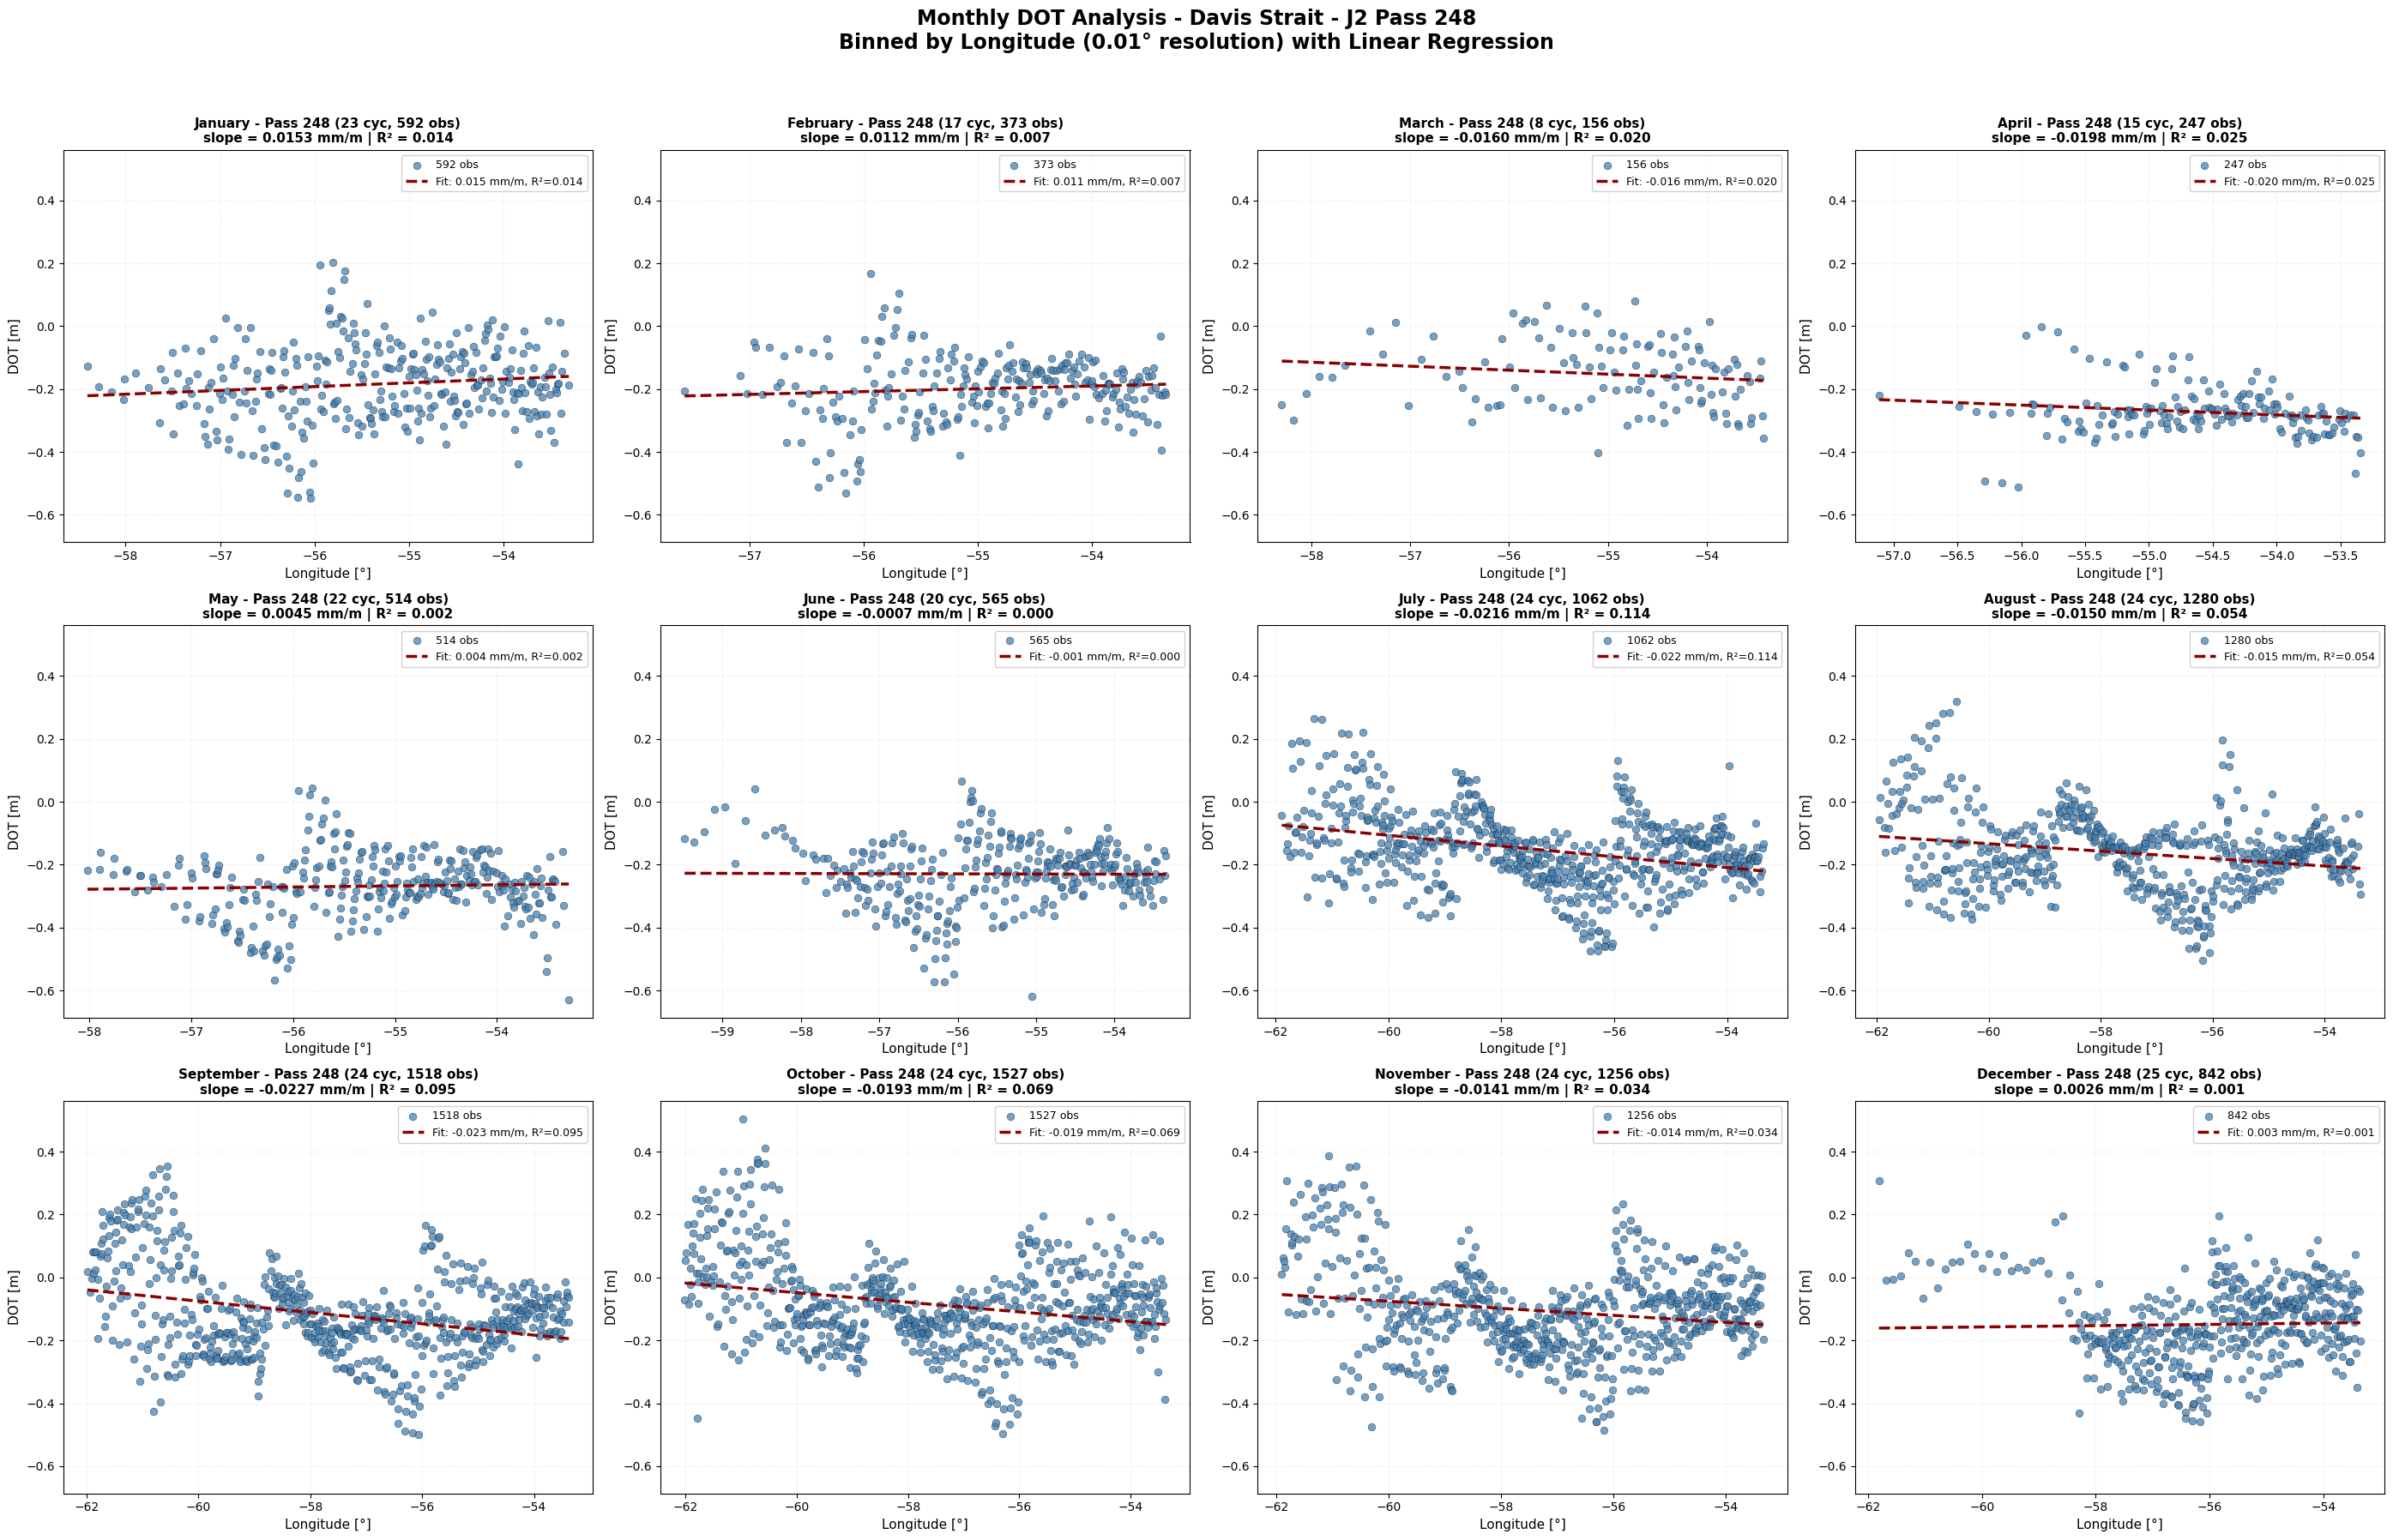


📊 MONTHLY SUMMARY
January     :   592 obs,  23 cyc, slope=+0.01527 mm/m, R²=0.014
February    :   373 obs,  17 cyc, slope=+0.01119 mm/m, R²=0.007
March       :   156 obs,   8 cyc, slope=-0.01598 mm/m, R²=0.020
April       :   247 obs,  15 cyc, slope=-0.01976 mm/m, R²=0.025
May         :   514 obs,  22 cyc, slope=+0.00449 mm/m, R²=0.002
June        :   565 obs,  20 cyc, slope=-0.00072 mm/m, R²=0.000
July        :  1062 obs,  24 cyc, slope=-0.02160 mm/m, R²=0.114
August      :  1280 obs,  24 cyc, slope=-0.01496 mm/m, R²=0.054
September   :  1518 obs,  24 cyc, slope=-0.02274 mm/m, R²=0.095
October     :  1527 obs,  24 cyc, slope=-0.01929 mm/m, R²=0.069
November    :  1256 obs,  24 cyc, slope=-0.01411 mm/m, R²=0.034
December    :   842 obs,  25 cyc, slope=+0.00256 mm/m, R²=0.001

✅ Monthly analysis complete!


In [ ]:
# ========================================
# 📊 MONTHLY DOT ANALYSIS - 12 SUBPLOTS
# ========================================

print("\n🔄 Creating monthly analysis (12 subplots)...")

# Conversion factor for slope (m/deg to mm/m)
R_EARTH = 111320.0
mean_latitude = float(j2_data["lat"].mean())
mean_lat_rad = np.deg2rad(mean_latitude)
meters_per_deg_lon = R_EARTH * np.cos(mean_lat_rad) * np.pi / 180.0

# Time info
time_min = j2_data["time"].min()
time_max = j2_data["time"].max()
cycle_min = int(j2_data["cycle"].min())
cycle_max = int(j2_data["cycle"].max())

print(f"   Time range: {time_min} to {time_max}")
print(f"   Mean latitude: {mean_latitude:.3f}°")
print(f"   1° longitude ≈ {meters_per_deg_lon:.1f} m")

# DOT range for consistent y-limits
dot_global_min = j2_data["dot"].min()
dot_global_max = j2_data["dot"].max()
dot_margin = 0.05 * (dot_global_max - dot_global_min)
y_min_global = dot_global_min - dot_margin
y_max_global = dot_global_max + dot_margin

# Month names
month_names = {
    1: "January", 2: "February", 3: "March", 4: "April",
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December",
}

# Create figure
fig, axes = plt.subplots(3, 4, figsize=(28, 18))
axes = axes.flatten()
monthly_results = []

for month_num in range(1, 13):
    ax = axes[month_num - 1]
    month_data = j2_data[j2_data["month"] == month_num].copy()
    
    if len(month_data) == 0:
        ax.text(0.5, 0.5, f"{month_names[month_num]}\n\nNo data available",
                ha="center", va="center", fontsize=13, transform=ax.transAxes,
                bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
        ax.set_xticks([])
        ax.set_yticks([])
        continue
    
    # Binning by longitude
    lon_min_m = month_data["lon"].min()
    lon_max_m = month_data["lon"].max()
    lon_bins_m = np.arange(lon_min_m, lon_max_m + LON_BIN_SIZE, LON_BIN_SIZE)
    
    if len(lon_bins_m) < 2:
        continue
    
    lon_centers_m = (lon_bins_m[:-1] + lon_bins_m[1:]) / 2
    dot_binned = []
    lon_binned = []
    
    for i in range(len(lon_bins_m) - 1):
        mask = (month_data["lon"] >= lon_bins_m[i]) & (month_data["lon"] < lon_bins_m[i + 1])
        dot_values = month_data.loc[mask, "dot"]
        if len(dot_values) > 0:
            dot_binned.append(dot_values.mean())
            lon_binned.append(lon_centers_m[i])
    
    dot_binned = np.array(dot_binned)
    lon_binned = np.array(lon_binned)
    valid_mask = ~np.isnan(dot_binned)
    lon_valid = lon_binned[valid_mask]
    dot_valid = dot_binned[valid_mask]
    
    if len(lon_valid) < 2:
        continue
    
    # Scatter plot
    ax.scatter(lon_valid, dot_valid, s=40, alpha=0.75, color='steelblue',
               edgecolor='k', linewidth=0.3,
               label=f"{len(month_data)} obs")
    
    # Linear regression
    slope_m_deg, intercept = np.polyfit(lon_valid, dot_valid, 1)
    fit_line = slope_m_deg * lon_valid + intercept
    
    ss_res = np.sum((dot_valid - fit_line) ** 2)
    ss_tot = np.sum((dot_valid - np.mean(dot_valid)) ** 2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    
    slope_mm_per_m = (slope_m_deg / meters_per_deg_lon) * 1000.0
    
    ax.plot(lon_valid, fit_line, linestyle="--", linewidth=2.5, color='darkred',
            label=f"Fit: {slope_mm_per_m:.3f} mm/m, R²={r_squared:.3f}")
    
    # Formatting
    ax.set_xlabel("Longitude [°]", fontsize=11)
    ax.set_ylabel("DOT [m]", fontsize=11)
    ax.grid(True, alpha=0.3, linestyle=":")
    ax.set_ylim(y_min_global, y_max_global)
    ax.tick_params(axis="both", labelsize=10)
    
    n_cycles = month_data["cycle"].nunique()
    title = f"{month_names[month_num]} - Pass {PASS_NUMBER} ({n_cycles} cyc, {len(month_data)} obs)\n"
    title += f"slope = {slope_mm_per_m:.4f} mm/m | R² = {r_squared:.3f}"
    ax.set_title(title, fontsize=11, fontweight="bold")
    ax.legend(fontsize=9, loc="best", framealpha=0.9)
    
    monthly_results.append({
        "month": month_num,
        "month_name": month_names[month_num],
        "n_obs": len(month_data),
        "n_cycles": n_cycles,
        "slope_mm_per_m": slope_mm_per_m,
        "r_squared": r_squared,
    })

# Figure title
fig_title = f"Monthly DOT Analysis - {strait_name} - {satellite_name} Pass {PASS_NUMBER}\n"
fig_title += f"Binned by Longitude ({LON_BIN_SIZE:.2f}° resolution) with Linear Regression"
fig.suptitle(fig_title, fontsize=17, fontweight="bold", y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.97])

if SAVE_OUTPUTS:
    fname = f"monthly_analysis_{satellite_name}_pass{PASS_NUMBER}_{SELECTED_STRAIT}.png"
    plt.savefig(OUTPUT_DIR / fname, dpi=300, bbox_inches='tight')
    print(f"\n💾 Saved: {OUTPUT_DIR / fname}")

plt.show()

# Print summary
print("\n" + "=" * 70)
print("📊 MONTHLY SUMMARY")
print("=" * 70)
for r in monthly_results:
    print(f"{r['month_name']:12s}: {r['n_obs']:5d} obs, {r['n_cycles']:3d} cyc, "
          f"slope={r['slope_mm_per_m']:+.5f} mm/m, R²={r['r_squared']:.3f}")
print("=" * 70)
print("\n✅ Monthly analysis complete!")


🔄 Creating slope timeline...

💾 Saved: /Users/nicolocaron/Desktop/ARCFRESH/plot slccii/SINGLE_STRAIT/slope_timeline_J2_pass248_davis.png


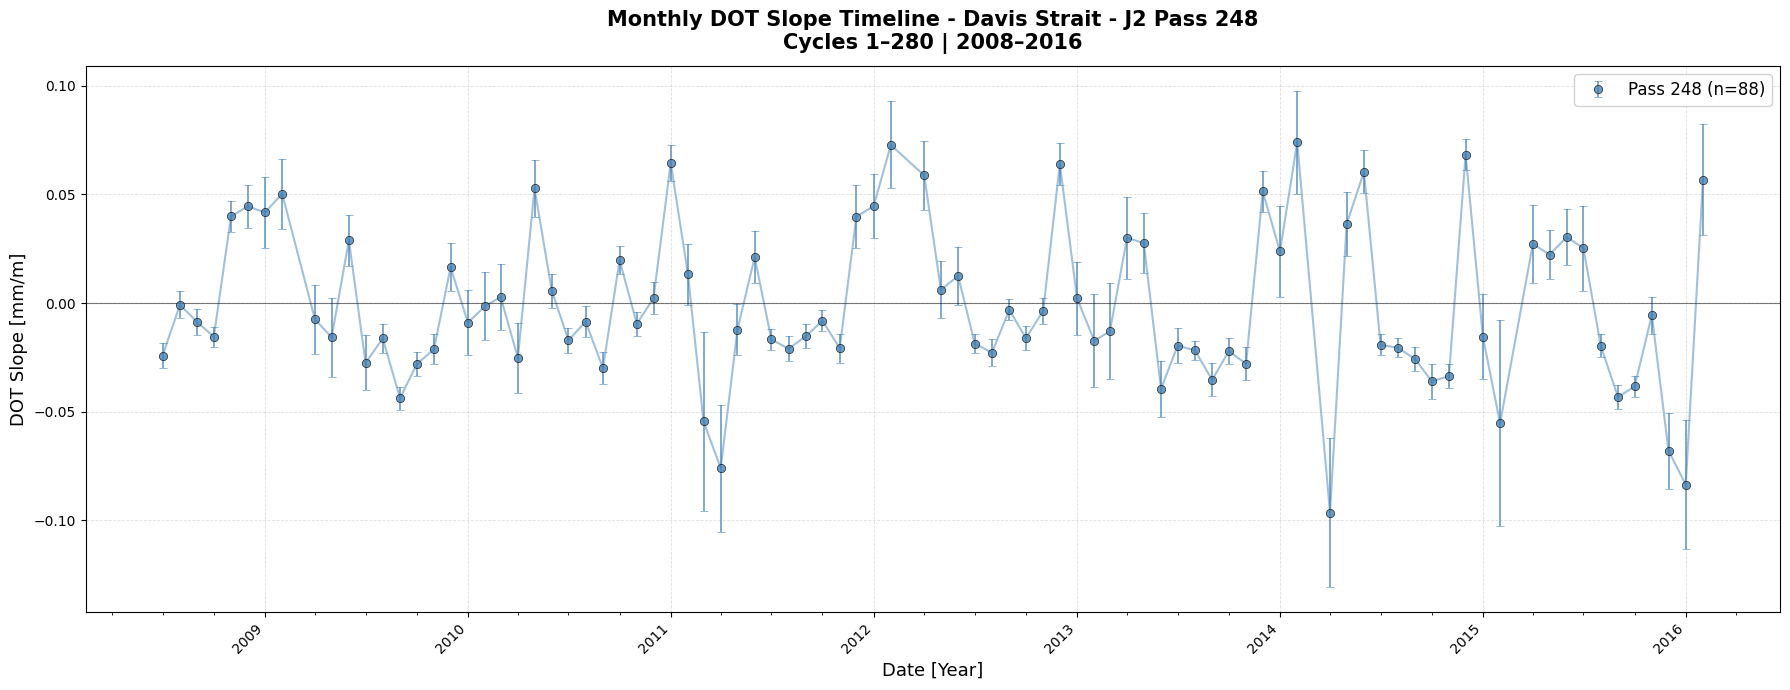


📈 SLOPE TIMELINE STATISTICS
Mean slope:  -0.0014 mm/m
Std slope:   0.0365 mm/m
Min slope:   -0.0965 mm/m
Max slope:   +0.0740 mm/m
Total months: 88

✅ Slope timeline complete!


In [ ]:
# ========================================
# 📈 SLOPE TIMELINE - MONTHLY EVOLUTION
# ========================================

print("\n🔄 Creating slope timeline...")

timeline_results = []
years_sorted = sorted(j2_data["year"].unique())

for year in years_sorted:
    for month in range(1, 13):
        group = j2_data[(j2_data["year"] == year) & (j2_data["month"] == month)].copy()
        if len(group) < 2:
            continue
        
        # Binning
        lon_min_g = group["lon"].min()
        lon_max_g = group["lon"].max()
        bins = np.arange(lon_min_g, lon_max_g + LON_BIN_SIZE, LON_BIN_SIZE)
        if len(bins) < 2:
            continue
        
        group["lon_bin"] = pd.cut(group["lon"], bins=bins, labels=False, include_lowest=True)
        binned = group.groupby("lon_bin").agg({"lon": "mean", "dot": "mean"}).dropna()
        if len(binned) < 3:
            continue
        
        lon_centers_t = binned["lon"].values
        dot_means = binned["dot"].values
        
        try:
            slope_m_deg, intercept, r_value, p_value, std_err_m_deg = stats.linregress(
                lon_centers_t, dot_means
            )
        except Exception:
            continue
        
        slope_mm_per_m = (slope_m_deg / meters_per_deg_lon) * 1000.0
        slope_err_mm_per_m = (std_err_m_deg / meters_per_deg_lon) * 1000.0
        
        timeline_results.append({
            "year": year,
            "month": month,
            "date": pd.to_datetime({"year": [year], "month": [month], "day": [1]})[0],
            "slope_mm_per_m": slope_mm_per_m,
            "slope_err_mm_per_m": slope_err_mm_per_m,
            "n_points": len(group),
            "r_squared": r_value**2,
        })

results_df_timeline = pd.DataFrame(timeline_results)

if results_df_timeline.empty:
    print("⚠️ No valid monthly slopes computed for timeline.")
else:
    # Create figure
    fig_t, ax_t = plt.subplots(figsize=(18, 7))
    
    # Light polyline
    ax_t.plot(results_df_timeline["date"], results_df_timeline["slope_mm_per_m"],
              color='steelblue', linewidth=1.5, alpha=0.5, zorder=1)
    
    # Errorbar points
    ax_t.errorbar(
        results_df_timeline["date"],
        results_df_timeline["slope_mm_per_m"],
        yerr=results_df_timeline["slope_err_mm_per_m"],
        fmt="o",
        markersize=6,
        color='steelblue',
        ecolor='steelblue',
        elinewidth=1.2,
        capsize=3,
        markeredgecolor="k",
        markeredgewidth=0.5,
        label=f"Pass {PASS_NUMBER} (n={len(results_df_timeline)})",
        zorder=2,
        alpha=0.8,
    )
    
    # Title and labels
    title_slope = f"Monthly DOT Slope Timeline - {strait_name} - {satellite_name} Pass {PASS_NUMBER}\n"
    title_slope += f"Cycles {cycle_min}–{cycle_max} | {time_min.year}–{time_max.year}"
    
    ax_t.set_title(title_slope, fontsize=15, fontweight="bold", pad=12)
    ax_t.set_xlabel("Date [Year]", fontsize=13)
    ax_t.set_ylabel("DOT Slope [mm/m]", fontsize=13)
    ax_t.grid(True, alpha=0.4, linestyle="--", linewidth=0.6)
    ax_t.axhline(0, color="k", linewidth=0.8, alpha=0.5)
    
    ax_t.xaxis.set_major_locator(mdates.YearLocator())
    ax_t.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax_t.xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45, ha="right")
    
    ax_t.legend(loc="best", fontsize=12, framealpha=0.9)
    plt.tight_layout()
    
    if SAVE_OUTPUTS:
        fname = f"slope_timeline_{satellite_name}_pass{PASS_NUMBER}_{SELECTED_STRAIT}.png"
        plt.savefig(OUTPUT_DIR / fname, dpi=300, bbox_inches='tight')
        print(f"\n💾 Saved: {OUTPUT_DIR / fname}")
    
    plt.show()
    
    # Statistics
    print("\n" + "=" * 70)
    print("📈 SLOPE TIMELINE STATISTICS")
    print("=" * 70)
    print(f"Mean slope:  {results_df_timeline['slope_mm_per_m'].mean():+.4f} mm/m")
    print(f"Std slope:   {results_df_timeline['slope_mm_per_m'].std():.4f} mm/m")
    print(f"Min slope:   {results_df_timeline['slope_mm_per_m'].min():+.4f} mm/m")
    print(f"Max slope:   {results_df_timeline['slope_mm_per_m'].max():+.4f} mm/m")
    print(f"Total months: {len(results_df_timeline)}")
    print("=" * 70)

print("\n✅ Slope timeline complete!")

## 📊 Analysis Complete!

All plots have been generated:
1. ✅ DOT Map
2. ✅ 3-Panel DOT Plot (Slope Timeline, Profile, Map)
3. ✅ Monthly Analysis (12 subplots)
4. ✅ Slope Timeline

**Method Used**: All analyses use **0.01° longitude binning** with **linear regression** for slope calculation.